In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import tensorflow as tf
import os
from skimage import io
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [2]:
def create_data_set(): 
    images_path = [ os.path.join("/content/drive/MyDrive/ANN/Datasets/yalefaces/", item)  for item in  os.listdir(
        "/content/drive/MyDrive/ANN/Datasets/yalefaces") ]
    image_data = []
    image_labels = []
    num = 0
    scaler = StandardScaler()
    for i,im_path in enumerate(images_path):
        im = io.imread(im_path)
        image_data.append(np.array(np.ravel(im), dtype='uint8'))
        label = os.path.split(im_path)[1].split(".")[1]
        image_labels.append(label)
    enc = LabelEncoder()
    image_labels = enc.fit_transform(np.array(image_labels))
    train_data, train_label = image_data[:9*11], image_labels[:9*11]
    val_data, val_label = image_data[9*11:13*11], image_labels[9*11:13*11]
    test_data, test_label = image_data[13*11:], image_labels[13*11:]
    
    train_data = scaler.fit_transform(train_data)
    val_data = scaler.transform(val_data)
    test_data = scaler.fit_transform(test_data)
    print('Number data in each group: ', len(train_data), len(val_data), len(test_data))
    
    return np.array(train_data), np.array(train_label), np.array(val_data), np.array(val_label), np.array(test_data), np.array(test_label)

In [3]:
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
  def __init__(self, patience=0):
    super(EarlyStoppingCallback, self).__init__()
    self.patience = patience

  def on_train_begin(self, logs=None):
    self.best = -np.Inf
    self.wait = 0
    self.stopped_epoch = 0

  def on_epoch_end(self, epoch, logs=None):
    current_accuracy = logs.get("accuracy")
    if np.greater(current_accuracy, self.best):
      self.best = current_accuracy
      self.wait = 0
      self.best_weights = self.model.get_weights()
    else:
      self.wait += 1
      if self.wait >= self.patience:
        self.stopped_epoch = epoch
        self.model.stop_training = True
        self.model.set_weights(self.best_weights)

  def on_train_end(self, logs=None):
    if self.stopped_epoch > 0:
      print("epoch: %d: early stopping" % self.stopped_epoch)

In [4]:
if __name__ == "__main__":
    train_data, train_label, val_data, val_label, test_data, test_label = create_data_set()

    train_label = tf.keras.utils.to_categorical(train_label, 11)
    val_label = tf.keras.utils.to_categorical(val_label, 11)

    tf.keras.backend.clear_session()
    cls_callback = EarlyStoppingCallback(patience=5)

    inp = tf.keras.Input(shape = (320*243), name="input")
    hidden = tf.keras.layers.Dense(128, activation='relu')(inp)
    hidden = tf.keras.layers.Dense(32, activation='relu')(hidden)
    outp = tf.keras.layers.Dense(11, activation='softmax')(hidden)

    model = tf.keras.Model(inputs=inp, outputs=outp)

    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
    history = model.fit(train_data, train_label, epochs=25, verbose=1, validation_data=(val_data,val_label))#, callbacks=[cls_callback]

Number data in each group:  99 44 22
Epoch 1/25
4/4 [==============================] - 1s 241ms/step - loss: 14.2249 - accuracy: 0.1520 - val_loss: 13.9327 - val_accuracy: 0.2500
Epoch 2/25
4/4 [==============================] - 0s 77ms/step - loss: 18.8386 - accuracy: 0.3367 - val_loss: 13.1985 - val_accuracy: 0.2500
Epoch 3/25
4/4 [==============================] - 0s 77ms/step - loss: 11.8759 - accuracy: 0.3189 - val_loss: 11.9737 - val_accuracy: 0.2500
Epoch 4/25
4/4 [==============================] - 0s 78ms/step - loss: 10.6563 - accuracy: 0.3206 - val_loss: 11.0888 - val_accuracy: 0.2500
Epoch 5/25
4/4 [==============================] - 0s 77ms/step - loss: 8.7424 - accuracy: 0.3850 - val_loss: 11.3335 - val_accuracy: 0.2500
Epoch 6/25
4/4 [==============================] - 0s 75ms/step - loss: 5.6591 - accuracy: 0.4890 - val_loss: 11.9980 - val_accuracy: 0.2273
Epoch 7/25
4/4 [==============================] - 0s 78ms/step - loss: 4.9848 - accuracy: 0.4219 - val_loss: 12.2409 -

In [5]:
test_pred = np.argmax(model.predict(test_data), axis=-1)
print(confusion_matrix(test_label, test_pred, np.arange(0,11)))
print(accuracy_score(test_label, test_pred))

[[1 0 0 0 0 0 0 0 0 0 1]
 [1 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 2 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 2 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 2]
 [1 0 0 0 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 1 0]]
0.3181818181818182


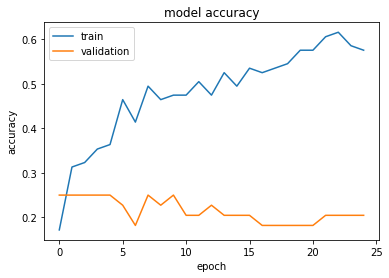

In [6]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()